In [ ]:
%%capture
!pip install shutil

In [ ]:
import os
import shutil
import joblib
import pickle
import json

#time management
from tqdm import tqdm
import time

#stats
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import cdist
from itertools import combinations

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.neighbors import kneighbors_graph, NearestNeighbors
from scipy.linalg import null_space, pinv, sqrtm
from numpy.linalg import eigh
from scipy.sparse.linalg import eigsh
from scipy.sparse.csgraph import laplacian

#DCSI

In [ ]:
def dcsi_score(X, labels):
    """
    Density-Based Clustering Selection Index (DCSI)

    """
    from sklearn.neighbors import NearestNeighbors
    from scipy.spatial.distance import cdist

    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)

    # Handle edge cases
    if n_clusters < 2:
        return 0.0

    # Calculate intra-cluster compactness
    intra_dists = []
    for k in unique_labels:
        if k == -1:
            continue
        cluster_points = X[labels == k]
        if len(cluster_points) > 1:
            centroid = np.mean(cluster_points, axis=0)
            intra_dists.extend(cdist(cluster_points, [centroid], 'euclidean').flatten())

    centroids = []
    for k in unique_labels:
        if k == -1:
            continue
        centroids.append(np.mean(X[labels == k], axis=0))

    if len(centroids) < 2:
        return 0.0

    inter_dists = cdist(centroids, centroids, 'euclidean')
    np.fill_diagonal(inter_dists, np.inf)
    avg_intra = np.mean(intra_dists) if intra_dists else 0
    min_inter = np.min(inter_dists) if inter_dists.size > 0 else 0

    # Norm DCSI
    if avg_intra == 0:
        return 1.0
    if min_inter == 0:
        return 0.0

    max_dist = np.max(cdist(X, X, 'euclidean'))
    if max_dist == 0:
        return 0.0

    normalized_dcsi = (min_inter / max_dist) * (1 - (avg_intra / max_dist))
    return np.clip(normalized_dcsi, 0.0, 1.0)

#FairDen

In [ ]:
#####CODE from https://jugit.fz-juelich.de/ias-8/fairden
class DCTree:
    """DCTree implementation for FairDEN"""
    def __init__(self, data, min_points=5, **kwargs):
        self.data = data
        self.min_points = min_points
        self.n_samples = data.shape[0]

    def dc_distances(self):
        """Compute DC distances"""
        nbrs = NearestNeighbors(n_neighbors=self.min_points).fit(self.data)
        distances, _ = nbrs.kneighbors(self.data)
        return distances[:, -1]


class DataLoader:
    """Enhanced DataLoader for FairSC and FairDEN"""
    def __init__(self, data, sensitive_attributes=None, num_clusters=3):
        self.data = data
        self.num_clusters = num_clusters

        # Handle sensitive attributes
        if sensitive_attributes is None:
            self.sensitive_attributes = {'dummy': np.zeros(data.shape[0], dtype=int)}
        else:
            self.sensitive_attributes = {}
            for name, values in sensitive_attributes.items():
                # Ensure attributes are non-negative integers
                self.sensitive_attributes[name] = np.abs(values).astype(int)

    def get_data(self, wo_sensitive=False):
        return self.data

    def get_encoded_data(self):
        """One-hot encode sensitive attributes for FairDEN"""
        return calculate_group_membership(self)

    def get_sensitive_columns(self):
        return self.sensitive_attributes

    def get_num_clusters(self):
        return self.num_clusters

    def get_num_categorical(self):
        """Number of categorical features for FairDEN"""
        return len(self.sensitive_attributes)

    def get_sens_mixed(self):
        """Get all sensitive attributes concatenated"""
        if not self.sensitive_attributes:
            return np.zeros((self.data.shape[0], 1))
        return np.column_stack(list(self.sensitive_attributes.values()))

def calculate_group_membership(data_loader):
    """Create one-hot encoded group membership matrix"""
    sensitive_columns = data_loader.get_sensitive_columns()

    if not sensitive_columns:
        return np.zeros((data_loader.get_data().shape[0], 1))

    encoded_arrays = []
    for name, values in sensitive_columns.items():
        n_categories = values.max() + 1
        encoded = np.zeros((values.size, n_categories), dtype=int)
        encoded[np.arange(values.size), values] = 1
        encoded_arrays.append(encoded)

    return np.concatenate(encoded_arrays, axis=1)


class FairSC:
    """Fixed Fair Spectral Clustering implementation"""
    def __init__(self, data_loader):
        self.data_loader = data_loader
        data = data_loader.get_data()

        # Create symmetric affinity matrix
        connectivity = kneighbors_graph(
            data,
            n_neighbors=min(15, data.shape[0]-1),
            mode="connectivity",
            include_self=False
        )
        self.affinity_matrix_ = 0.5 * (connectivity + connectivity.T).toarray()

    def run(self, k):
        try:
            H, labels = self._fair_spectral_clustering(k)
            return labels
        except Exception as e:
            print(f"FairSC failed: {str(e)}")
            return np.zeros(self.data_loader.get_data().shape[0])

    def _fair_spectral_clustering(self, k):
        W = self.affinity_matrix_
        n = W.shape[0]

        # Compute L
        D = np.diag(np.sum(W, axis=1))
        L = D - W

        # Compute fairness constraints
        G = calculate_group_membership(self.data_loader)
        F = np.column_stack([
            G[:, s] - (G[:, s].sum() / n) * np.ones(n)
            for s in range(G.shape[1])
        ])

        # Compute null space projection
        Z = null_space(F.T)
        if Z.size == 0:
            Z = np.eye(n)

        # Project L
        Z_L_Z = Z.T @ L @ Z
        Z_L_Z = (Z_L_Z + Z_L_Z.T) / 2

        # Compute eigenvectors
        try:
            eigvals, Y = eigh(Z_L_Z)
        except:
            eigvals, Y = eigsh(Z_L_Z, k=min(k, Z_L_Z.shape[0]-1), which='SA')

        # Get k smallest eigenvectors
        indices = np.argsort(eigvals)[:k]
        H = Z @ Y[:, indices]

        # K-means clustering
        return H, KMeans(n_clusters=k, n_init=10).fit(H).labels_

class FairDEN:
    """FairDEN implementation"""

    def __init__(self, data_loader, min_pts=5, alpha='0'):
        self.data_loader = data_loader
        self.min_points = min_pts
        self.alpha = alpha

        try:
            data = data_loader.get_data()
            if data.ndim == 1:
                data = data.reshape(-1, 1)

            self.data = data
            self._setup()
        except Exception as e:
            raise RuntimeError(f"FairDEN initialization failed: {str(e)}")

    def _setup(self):
        """Init"""
        # Compute sim
        self.sim_matrix = self._compute_similarity()
        if self.sim_matrix.ndim != 2:
            self.sim_matrix = self.sim_matrix.reshape(len(self.data), -1)

        # Compute degree matrix (D) and Laplacian (L)
        degrees = np.sum(self.sim_matrix, axis=1)
        D = np.diag(degrees)
        self.L = D - self.sim_matrix

        # Compute fairness constraints (F)
        G = calculate_group_membership(self.data_loader)
        if G.ndim == 1:
            G = G.reshape(-1, 1)

        n = G.shape[0]
        ones = np.ones(n)
        F_columns = []

        for s in range(G.shape[1]):
            col = G[:, s]
            if col.ndim == 1:
                col = col.reshape(-1, 1)
            F_columns.append(col - (np.sum(col) / n) * ones)

        self.F = np.hstack(F_columns) if F_columns else np.zeros((n, 1))
        if self.F.ndim == 1:
            self.F = self.F.reshape(-1, 1)

        # Compute null space (Z)
        try:
            self.Z = null_space(self.F.T, rcond=0.001)
            if self.Z.size == 0:
                self.Z = np.eye(n)
            elif self.Z.ndim == 1:
                self.Z = self.Z.reshape(-1, 1)
        except:
            self.Z = np.eye(n)

        # Compute Q matrix
        try:
            ZT_D_Z = self.Z.T @ D @ self.Z
            if ZT_D_Z.ndim == 0:
                ZT_D_Z = np.array([[ZT_D_Z]])
            self.Q = sqrtm(ZT_D_Z)
            self.Q_inv = pinv(self.Q)
        except:
            self.Q = np.eye(self.Z.shape[1])
            self.Q_inv = np.eye(self.Z.shape[1])

        # Compute projected L
        try:
            ZT_L_Z = self.Z.T @ self.L @ self.Z
            if ZT_L_Z.ndim == 0:
                ZT_L_Z = np.array([[ZT_L_Z]])
            self.Z_lap = self.Q_inv.T @ ZT_L_Z @ self.Q_inv
            self.Z_lap = (self.Z_lap + self.Z_lap.T) / 2
        except:
            self.Z_lap = np.eye(self.Z.shape[1])

        # Compute eigenvectors
        try:
            if self.Z_lap.shape[0] > 1:
                self.eig_vals, self.eig_vecs = eigsh(self.Z_lap, k=min(10, self.Z_lap.shape[0]-1), which='SA')
            else:
                self.eig_vals, self.eig_vecs = np.array([0]), np.eye(1)
        except:
            self.eig_vals, self.eig_vecs = np.array([0]), np.eye(1)

    def _compute_similarity(self):
        """Compute DC-based similarity matrix"""
        # Compute DC distances
        nbrs = NearestNeighbors(n_neighbors=self.min_points).fit(self.data)
        distances, _ = nbrs.kneighbors(self.data)
        dc_dist = distances[:, -1]

        # Convert to similarity
        sim = 1 - (dc_dist / np.linalg.norm(dc_dist))
        sim = (sim - np.min(sim)) / (np.max(sim) - np.min(sim))

        # Create symmetric similarity matrix
        sim_matrix = np.zeros((len(self.data), len(self.data)))
        for i in range(len(self.data)):
            for j in range(i+1, len(self.data)):
                sim_matrix[i,j] = sim_matrix[j,i] = (sim[i] + sim[j]) / 2

        if self.alpha == 'avg':
            encoded = self.data_loader.get_encoded_data()
            if encoded.ndim == 1:
                encoded = encoded.reshape(-1, 1)
            num_features = self.data.shape[1]
            num_cat = self.data_loader.get_num_categorical()
            sim_matrix = (num_features * sim_matrix + num_cat * encoded) / (num_features + num_cat)
            sim_matrix = (sim_matrix - np.min(sim_matrix)) / (np.max(sim_matrix) - np.min(sim_matrix))

        np.fill_diagonal(sim_matrix, 0)
        return sim_matrix

    def run(self, k=2):
        """Run FairDEN"""
        try:
            current_k = k
            while True:
                # Get subspace representation
                Y = self.eig_vecs[:, :current_k] if self.eig_vecs.ndim > 1 else self.eig_vecs.reshape(-1, 1)
                H = self.Z @ self.Q_inv @ Y
                H = np.real(H)
                if H.ndim == 1:
                    H = H.reshape(-1, 1)

                # Cluster in subspace
                if H.shape[0] > 1:
                    labels = KMeans(n_clusters=current_k, n_init=10).fit(H).labels_
                else:
                    labels = np.zeros(1)

                # Filter small clusters
                unique, counts = np.unique(labels, return_counts=True)
                for label, count in zip(unique, counts):
                    if count < self.min_points:
                        labels[labels == label] = -1

                # Check cluster count
                valid_clusters = len(set(labels)) - (1 if -1 in labels else 0)
                if valid_clusters >= k:
                    break
                current_k += 1

            new_labels = np.full_like(labels, -1)
            for i, cluster in enumerate(sorted(set(labels) - {-1})):
                new_labels[labels == cluster] = i

            return new_labels
        except Exception as e:
            print(f"FairDEN clustering failed: {str(e)}")
            return np.zeros(len(self.data))

In [ ]:
def run_clustering_comparison(X_all, sensitive_attributes=None, n_clusters=3):
    """Compare clustering methods"""

    X_scaled = StandardScaler().fit_transform(X_all)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

   # Baselines
    methods = {
        "DBSCAN": AgglomerativeClustering(n_clusters=n_clusters),
        "K-Means": KMeans(n_clusters=n_clusters, random_state=42),
    }

    # FairDen + FairSC
    data_loader = DataLoader(X_scaled, sensitive_attributes, n_clusters)

    try:
        methods["FairSC"] = FairSC(data_loader).run
    except Exception as e:
        print(f"FairSC init failed: {str(e)}")

    try:
        methods["FairDEN"] = FairDEN(data_loader, min_pts=5).run
    except Exception as e:
        print(f"FairDEN init failed: {str(e)}")

    grid_methods = [
        ["DBSCAN", "K-Means"],
        ["FairSC", "FairDEN"]
    ]

    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)

    results = []

    for i in range(2):
        for j in range(2):
            name = grid_methods[i][j]
            if name not in methods:
                axs[i,j].axis('off')
                continue

            try:
                model = methods[name]
                labels = model(n_clusters) if callable(model) else model.fit_predict(X_scaled)

                unique_labels = set(labels)
                if len(unique_labels) > 1:
                    results.append({
                        "Method": name,
                        "Silhouette": silhouette_score(X_scaled, labels), # SC
                        "DCSI": dcsi_score(X_scaled, labels),  #  DCSI
                        "Clusters": len(unique_labels) - (1 if -1 in unique_labels else 0),
                        # "Noise Points": np.sum(labels == -1) if -1 in labels else 0
                    })
                    scatter = axs[i,j].scatter(X_pca[:, 0], X_pca[:, 1], c=labels,
                                              cmap='coolwarm', alpha=0.4, s=20)
                    axs[i,j].set_title(f"{name}", pad=10)
                    axs[i,j].set_xlabel("PC1")
                    axs[i,j].set_ylabel("PC2")
                    axs[i,j].grid(True, linestyle='--', alpha=0.5)

                    plt.colorbar(scatter, ax=axs[i,j], label="Cluster")

            except Exception as e:
                print(f"{name} failed: {str(e)}")
                axs[i,j].axis('off')

    results_df = pd.DataFrame(results)
    print("\nClustering Performance Comparison:")
    print(results_df.to_markdown(index=False, floatfmt=".3f"))

    results_json = results_df.set_index("Method")[["Silhouette", "DCSI"]].to_dict(orient="index")

    with open("results.json", "w") as f:
         json.dump(results_json, f, indent=4)


    plt.tight_layout()
    plt.show()

    return results_json

#AGORA-US-I-100


Clustering Performance Comparison:
| Method   |   Silhouette |   DCSI |   Clusters |
|:---------|-------------:|-------:|-----------:|
| DBSCAN   |        0.453 |  0.258 |          3 |
| K-Means  |        0.138 |  0.091 |          3 |
| FairSC   |       -0.263 |  0.087 |          3 |
| FairDEN  |        0.419 |  0.139 |          3 |


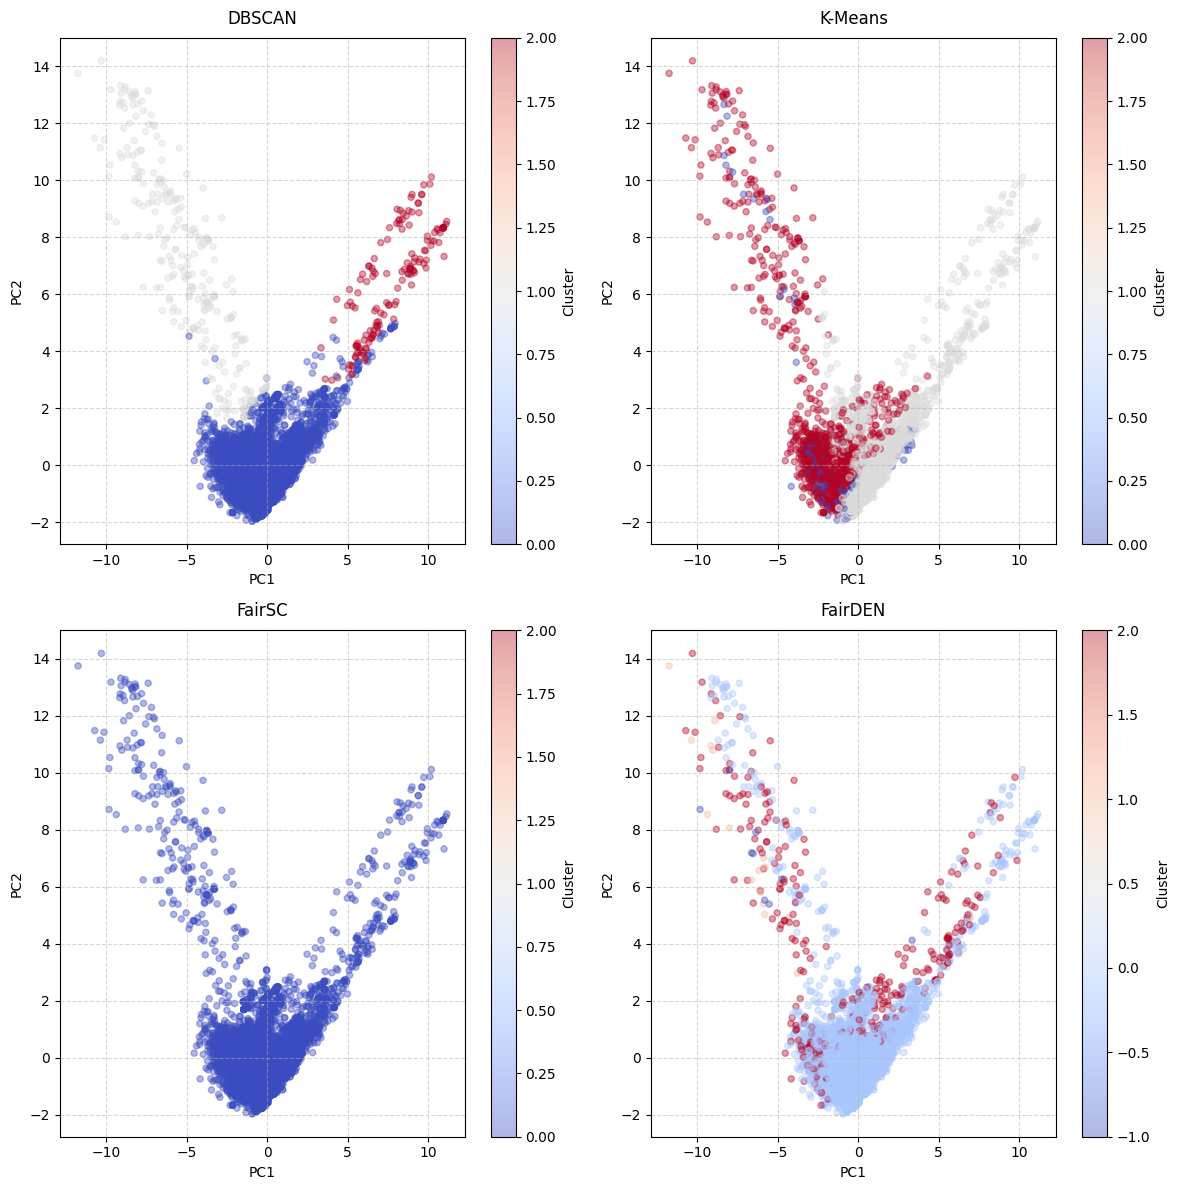

In [ ]:
X = np.load("/content/AG_US-I-100.npy")

# Run
results = run_clustering_comparison(
X,
sensitive_attributes=None,
n_clusters=3
)

#AGORA-US-II-100


Clustering Performance Comparison:
| Method   |   Silhouette |   DCSI |   Clusters |
|:---------|-------------:|-------:|-----------:|
| DBSCAN   |        0.453 |  0.258 |          3 |
| K-Means  |        0.138 |  0.091 |          3 |
| FairSC   |       -0.263 |  0.087 |          3 |
| FairDEN  |        0.419 |  0.139 |          3 |


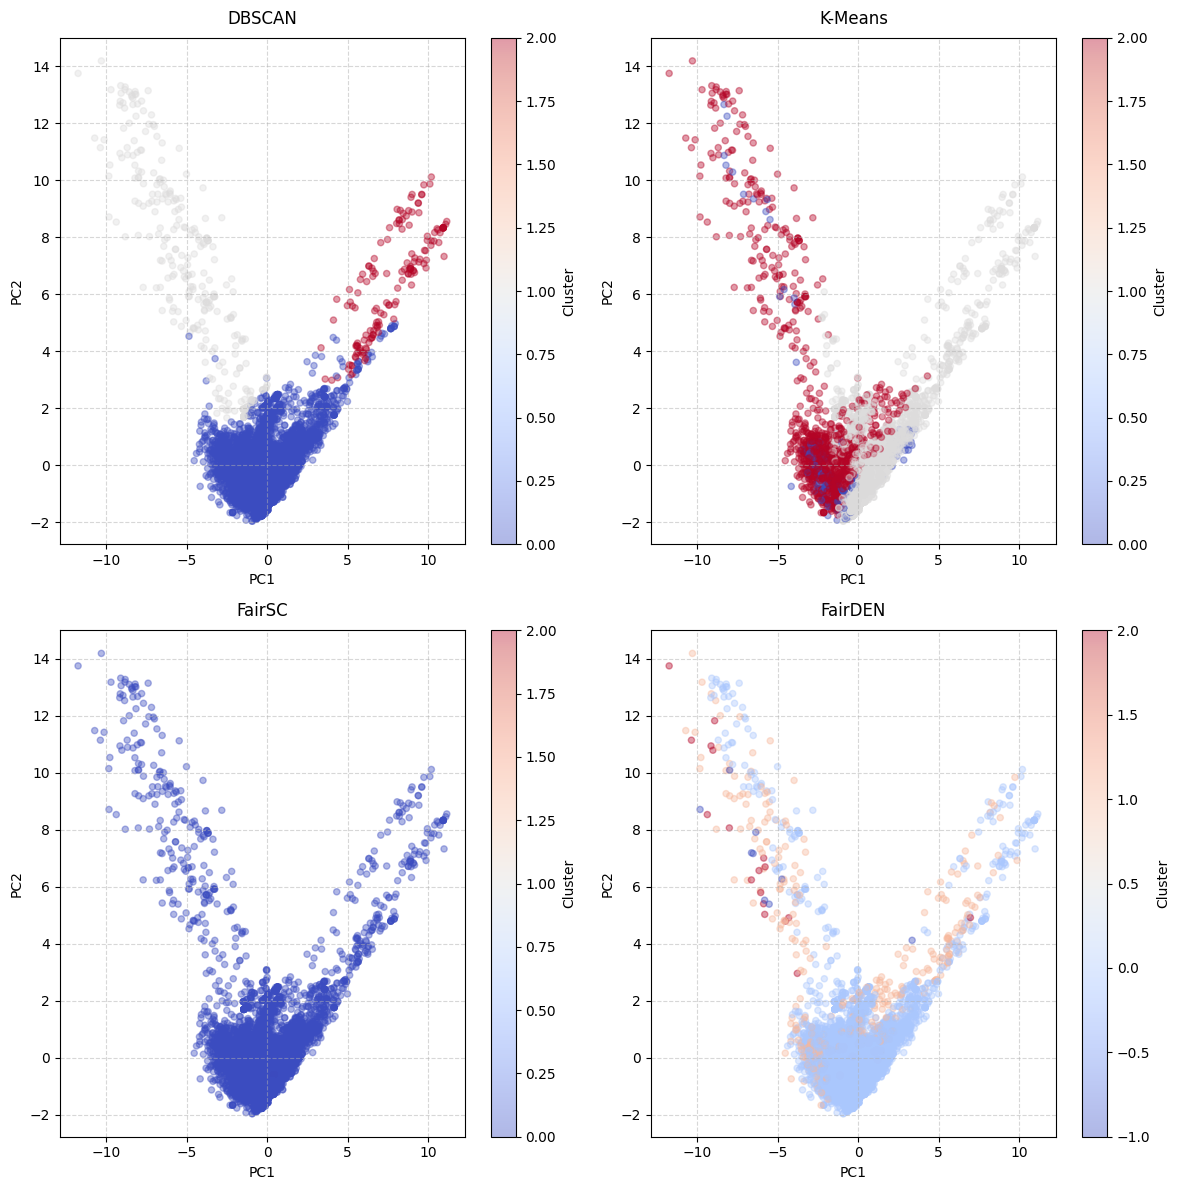

In [ ]:
X = np.load("/content/AG_US-II-100.npy")

# Run
results = run_clustering_comparison(
X,
sensitive_attributes=None,
n_clusters=3
)

#AGORA-US-I-50


Clustering Performance Comparison:
| Method   |   Silhouette |   DCSI |   Clusters |
|:---------|-------------:|-------:|-----------:|
| DBSCAN   |        0.594 |  0.363 |          3 |
| K-Means  |        0.426 |  0.208 |          3 |
| FairSC   |        0.153 |  0.059 |          3 |
| FairDEN  |        0.494 |  0.130 |          3 |


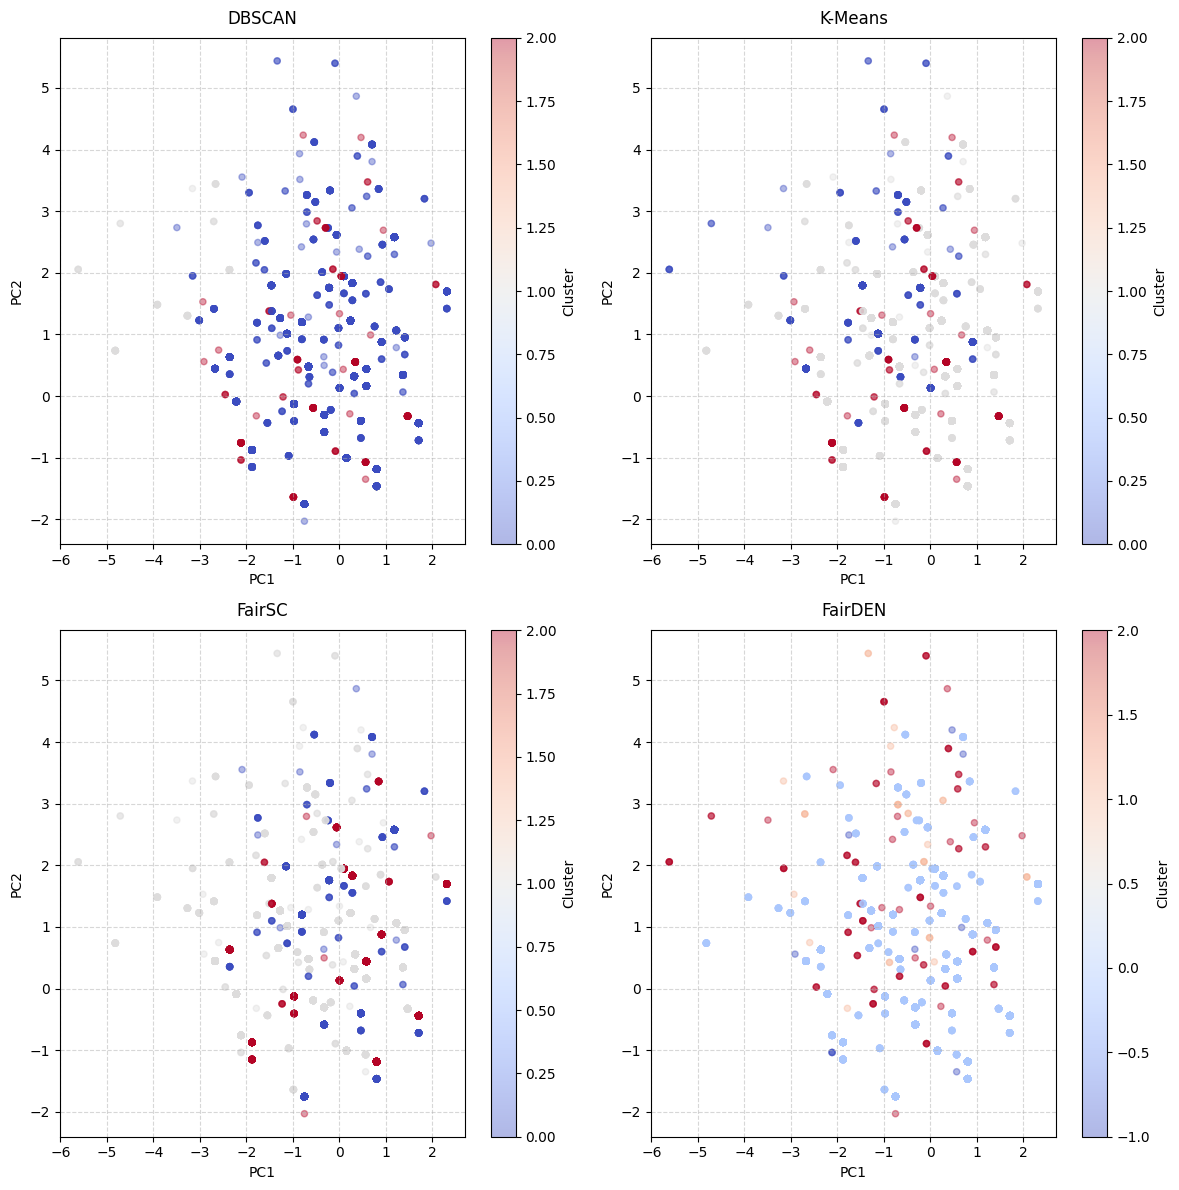

In [ ]:
X = np.load("/content/AG_US-I-50.npy")

# Run
results = run_clustering_comparison(
X,
sensitive_attributes=None,
n_clusters=3
)

#AGORA-US-II-50


Clustering Performance Comparison:
| Method   |   Silhouette |   DCSI |   Clusters |
|:---------|-------------:|-------:|-----------:|
| DBSCAN   |        0.271 |  0.054 |          3 |
| K-Means  |        0.191 |  0.077 |          3 |
| FairSC   |        0.277 |  0.084 |          3 |
| FairDEN  |        0.014 |  0.018 |          3 |


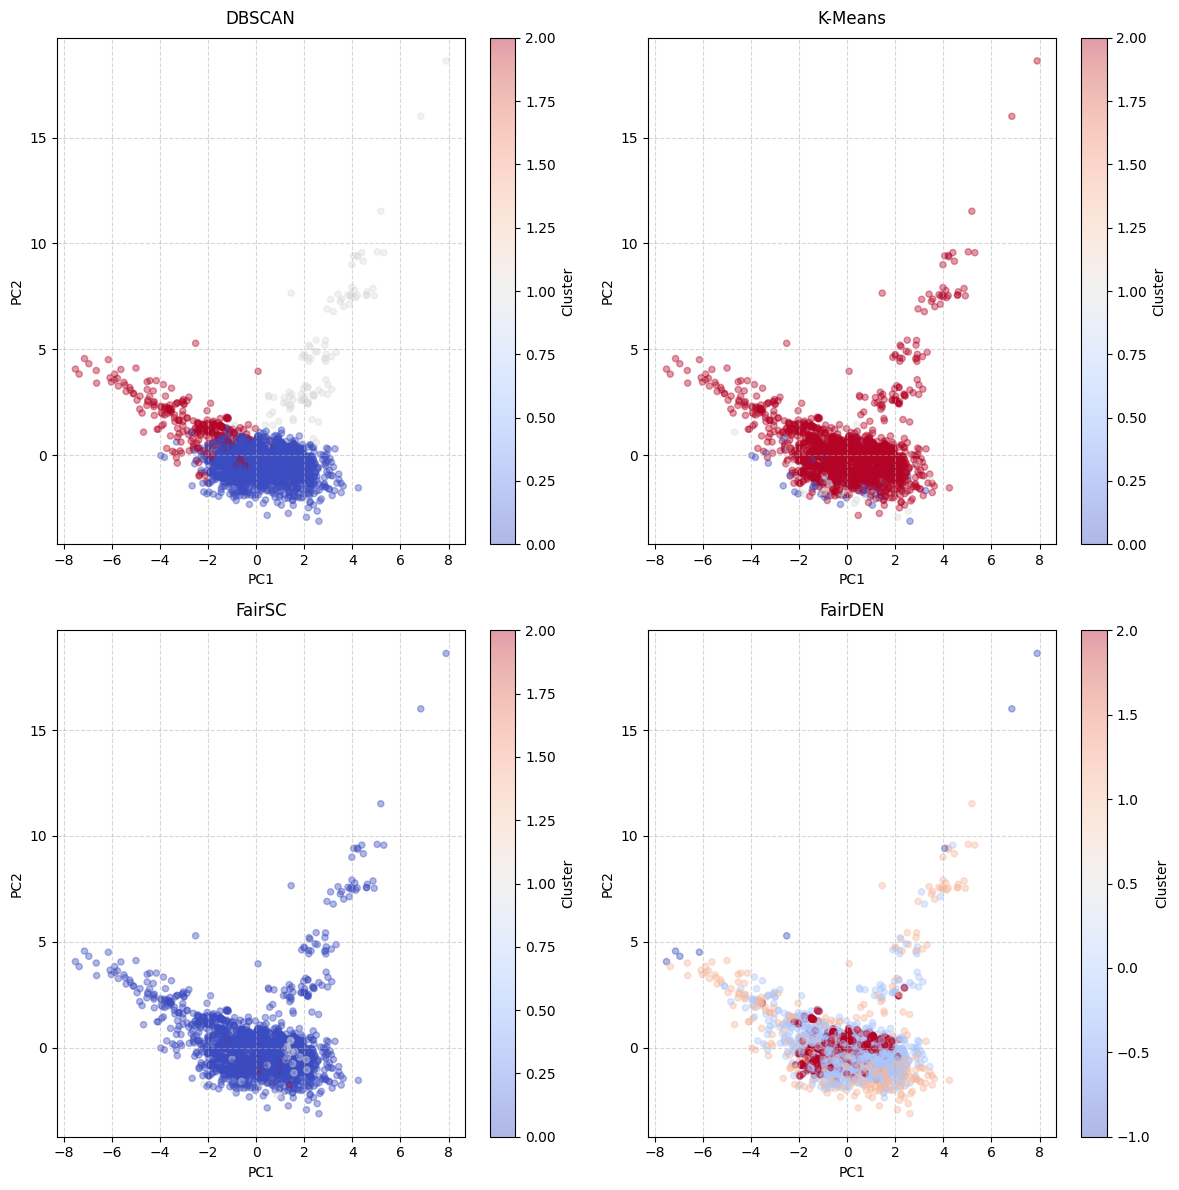

In [ ]:
X = np.load("/content/AG_US-II-50.npy")

# Run
results = run_clustering_comparison(
X,
sensitive_attributes=None,
n_clusters=3
)

#CARVEME-US-I-100


Clustering Performance Comparison:
| Method   |   Silhouette |   DCSI |   Clusters |
|:---------|-------------:|-------:|-----------:|
| DBSCAN   |        0.212 |  0.165 |          5 |
| K-Means  |        0.101 |  0.074 |          5 |
| FairSC   |       -0.165 |  0.061 |          5 |
| FairDEN  |        0.126 |  0.052 |          5 |


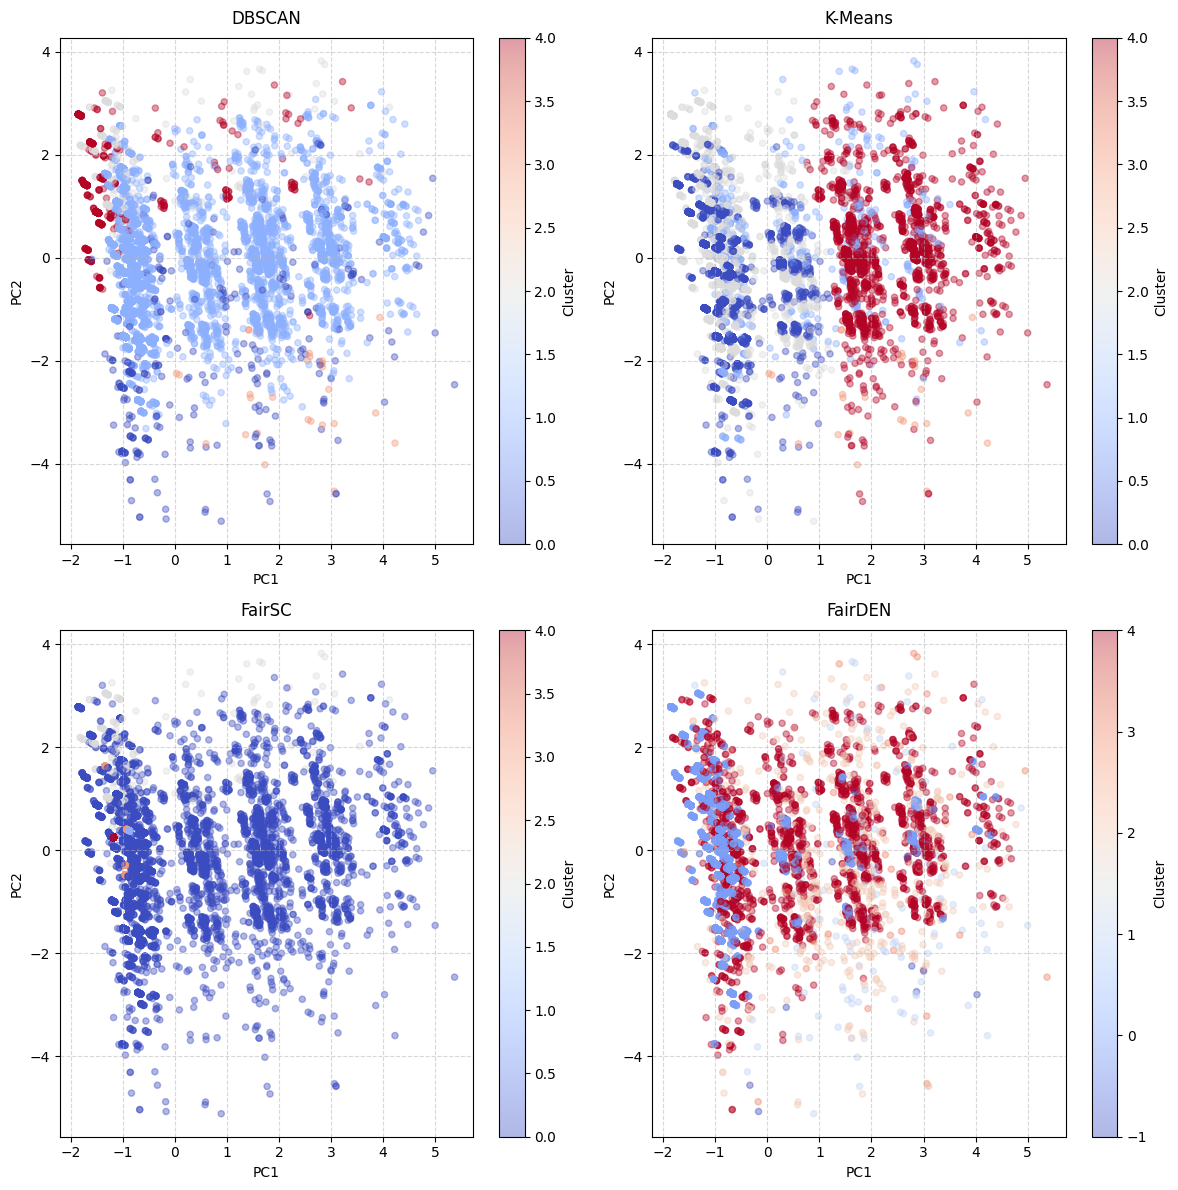

In [ ]:
X = np.load("/content/CM_US-I-100.npy")

# Run
results = run_clustering_comparison(
X,
sensitive_attributes=None,
n_clusters=5
)

#CARVEME-US-II-100


Clustering Performance Comparison:
| Method   |   Silhouette |   DCSI |   Clusters |
|:---------|-------------:|-------:|-----------:|
| DBSCAN   |        0.294 |  0.088 |          5 |
| K-Means  |        0.264 |  0.091 |          5 |
| FairSC   |        0.137 |  0.050 |          5 |
| FairDEN  |        0.387 |  0.091 |          5 |


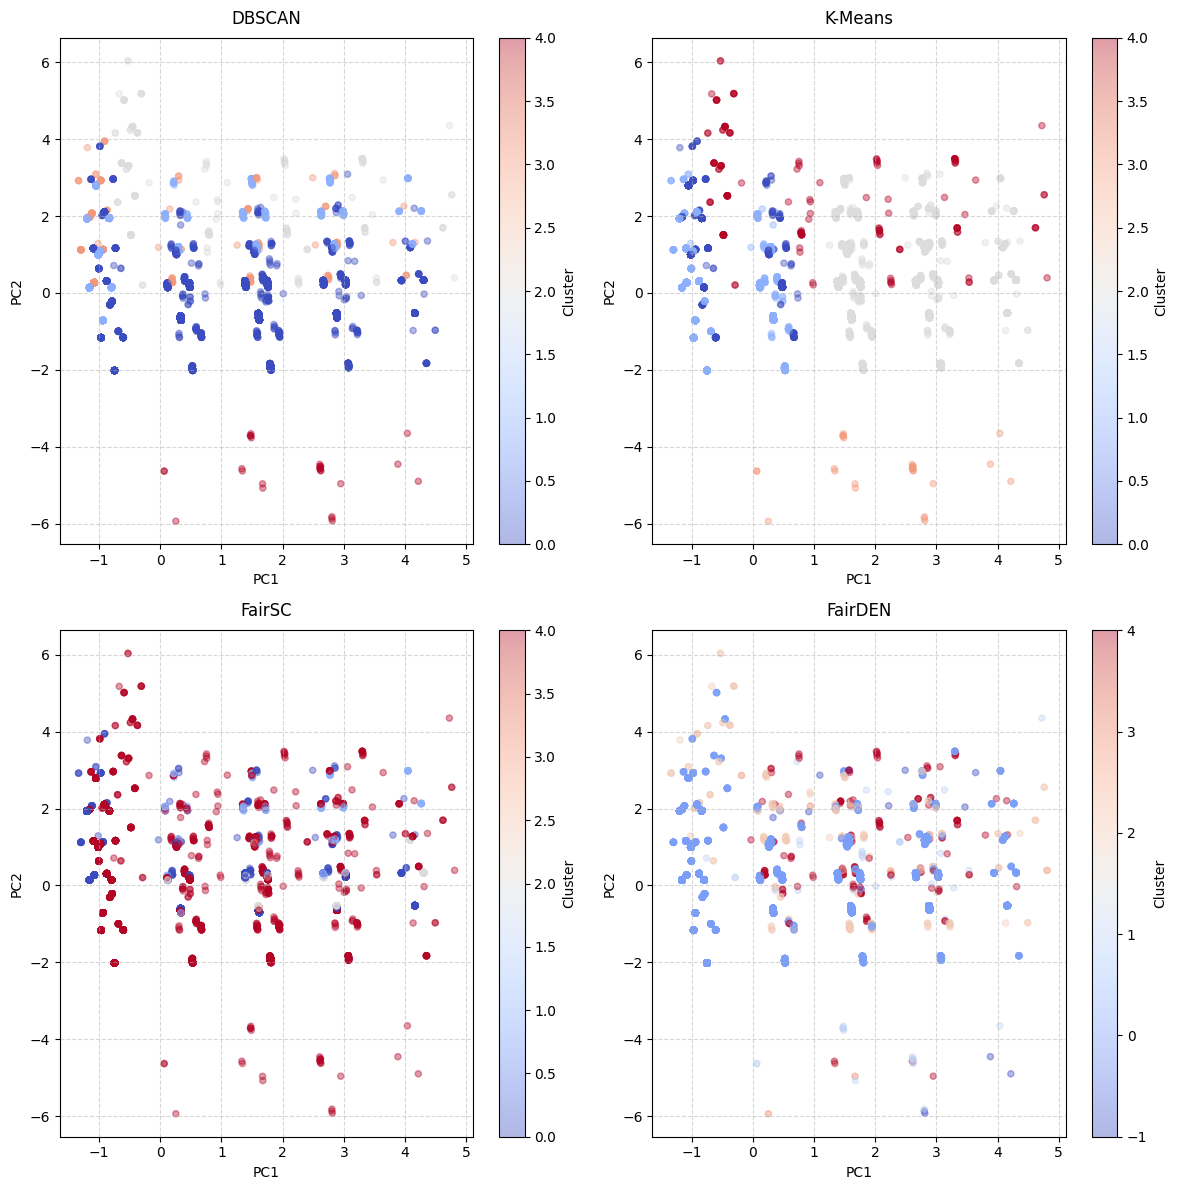

In [ ]:
X = np.load("/content/CM_US-II-100.npy")

# Run
results = run_clustering_comparison(
X,
sensitive_attributes=None,
n_clusters=5
)

#CARVEME-US-I-50


Clustering Performance Comparison:
| Method   |   Silhouette |   DCSI |   Clusters |
|:---------|-------------:|-------:|-----------:|
| DBSCAN   |        0.277 |  0.122 |          5 |
| K-Means  |        0.207 |  0.115 |          5 |
| FairSC   |       -0.125 |  0.061 |          5 |
| FairDEN  |        0.236 |  0.082 |          5 |


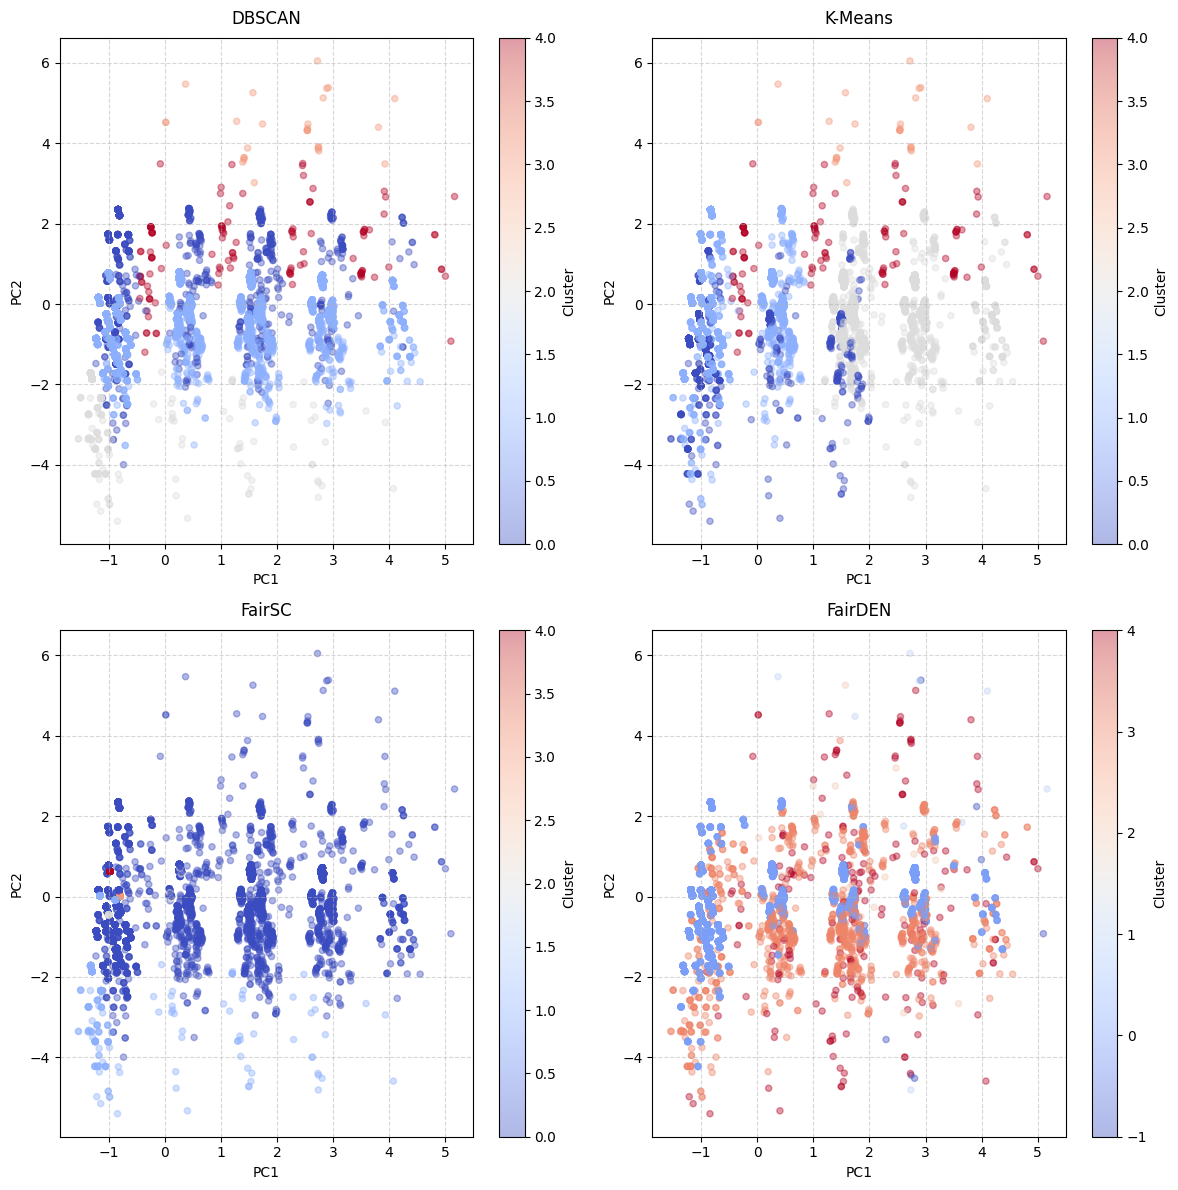

In [ ]:
X = np.load("/content/CM_US-I-50.npy")

# Run
results = run_clustering_comparison(
X,
sensitive_attributes=None,
n_clusters=5
)

#CARVEME-US-II-50


Clustering Performance Comparison:
| Method   |   Silhouette |   DCSI |   Clusters |
|:---------|-------------:|-------:|-----------:|
| DBSCAN   |        0.308 |  0.061 |          5 |
| K-Means  |        0.309 |  0.091 |          5 |
| FairSC   |        0.095 |  0.070 |          5 |
| FairDEN  |        0.421 |  0.071 |          5 |


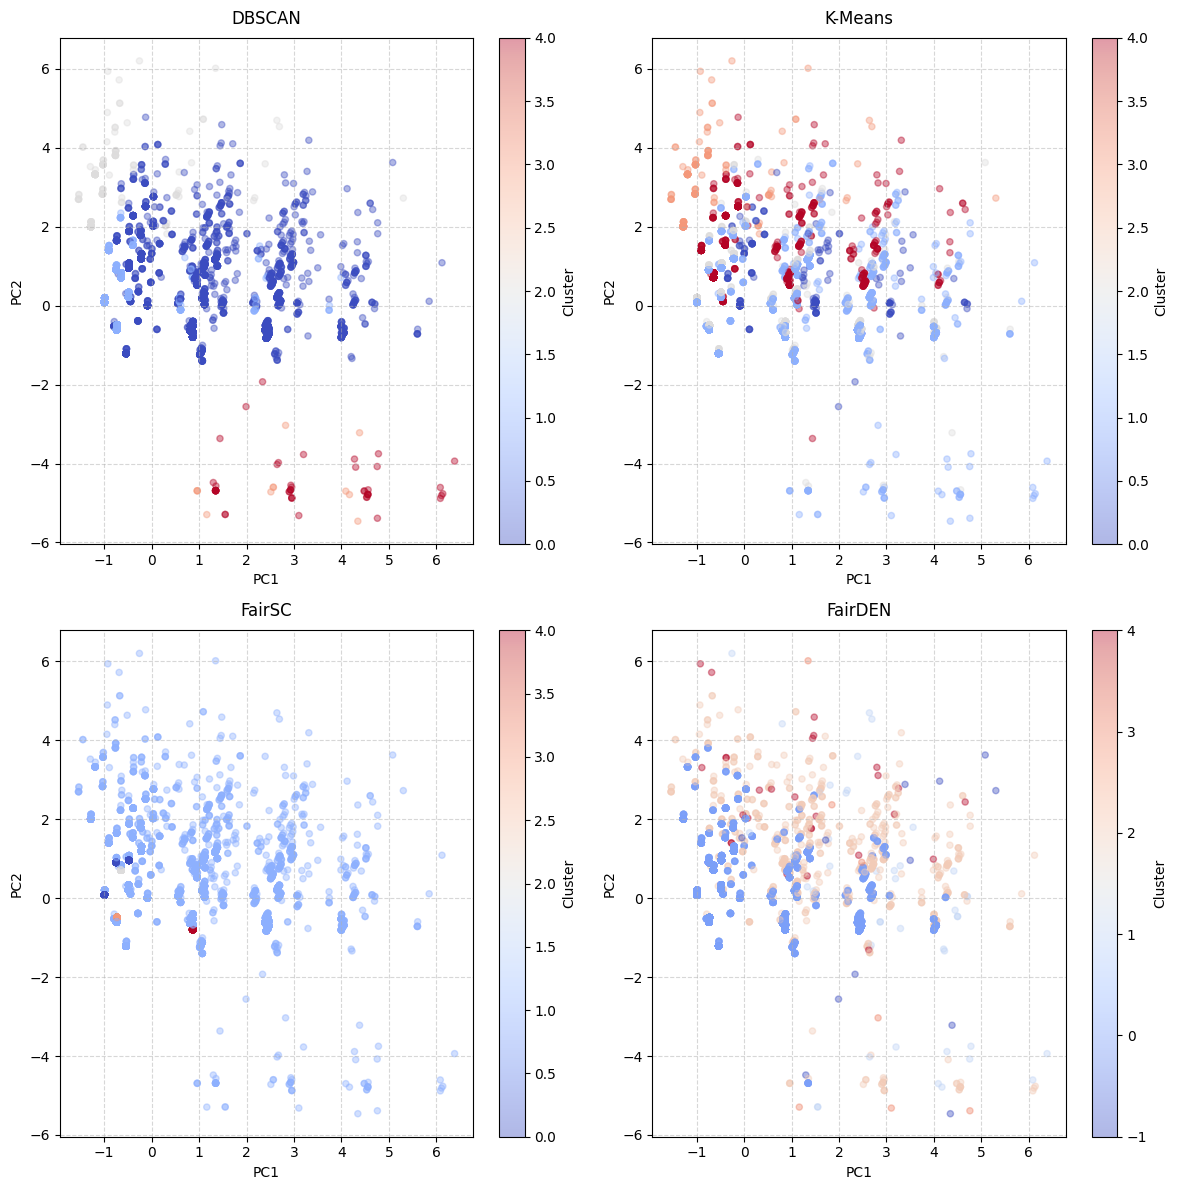

In [ ]:
X = np.load("/content/CM_US-II-50.npy")

# Run
results = run_clustering_comparison(
X,
sensitive_attributes=None,
n_clusters=5
)